# Подключение библиотек

In [105]:
import pandas as pd
import numpy as np
import tsv

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import pymorphy2

In [5]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [6]:
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Загрузка и предобработка данных

In [8]:
text_data = pd.read_table('train.tsv')

In [9]:
text_data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


<AxesSubplot:xlabel='is_fake', ylabel='Count'>

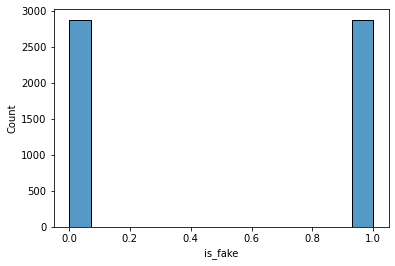

In [10]:
sns.histplot(text_data['is_fake'])

##### Количество реальных и выдуманных новостей сбалансировано

In [11]:
text_data.isna().sum()

title      0
is_fake    0
dtype: int64

## Удаление стоп-слов

In [12]:
stop_words = stopwords.words('russian')

In [13]:
text_data['title'] = text_data['title'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

## Удаление знаков препинания

In [14]:
def remove_punctuations(text):
    for punctuation in (string.punctuation + "«" + "»"):
        text = text.replace(punctuation, '')
    return text

In [15]:
text_data['title'] = text_data['title'].apply(remove_punctuations)

## Лемматизация текста

In [16]:
morph = pymorphy2.MorphAnalyzer()

In [17]:
text_data['title'] = text_data['title'].apply(lambda words: ' '.join(morph.normal_forms(word)[0] for word in words.split() ))

In [18]:
text_data

,title,is_fake
0,москвич владимир клутина прийти счёт вмешатель...,1
1,агент кокорин назвать езда встречка житейский ...,0
2,госдума рассмотреть возможность введение секре...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный завести дело недоносительство...,1
...,...,...
5753,эдди чемберс получить сотрясение мозг бой кличко,0
5754,правительство застроить россия нефтепродуктопр...,0
5755,я стыдно дед новый канцлер фрг обратиться перв...,1
5756,туркмения декабрь начать поставка газ китай,0


## Облако слов для реальный заголовков

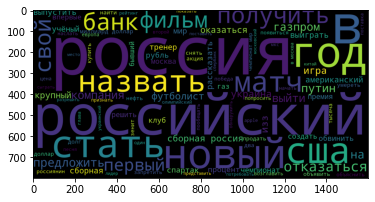

In [19]:
wordcloud = WordCloud(max_words = 100,  width = 1600 , height = 800).generate(" ".join(text_data[text_data.is_fake == 0].title))
plt.imshow(wordcloud)

## Облако слов для выдуманных заголовков

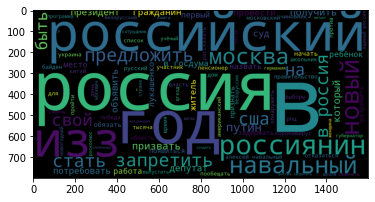

In [20]:
wordcloud = WordCloud(max_words = 100,  width = 1600 , height = 800).generate(" ".join(text_data[text_data.is_fake == 1].title))
plt.imshow(wordcloud)

## Количество символов в заголовке

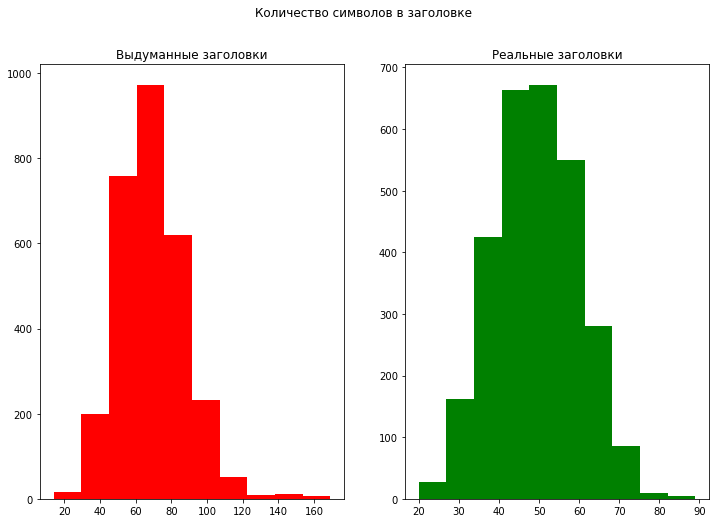

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=text_data[text_data.is_fake == 1]['title'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Выдуманные заголовки')
text_len=text_data[text_data.is_fake == 0]['title'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Реальные заголовки')
fig.suptitle('Количество символов в заголовке')
plt.show()

##### По графикам видно что реальные заголовки немного короче выдуманных

# Обучение и выбор модели

In [22]:
X_train = text_data.title

In [23]:
y_train = text_data.is_fake

### Наивный байесовский классификатор

In [24]:
NB_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                  ])

In [25]:
scores_NB = cross_val_score(NB_clf, X_train, y_train, cv=5, scoring='f1_macro')

In [26]:
np.around(np.mean(scores_NB), decimals=2)

0.84

### Стохастический градиентный спуск

In [27]:
SGD_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=1e-3)),
                    ])

In [28]:
scores_SGD = cross_val_score(SGD_clf, X_train, y_train, cv=5, scoring='f1_macro')

In [29]:
np.around(np.mean(scores_SGD), decimals=2)

0.84

### Классификация линейных опорных векторов

In [30]:
Lin_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC(loss='squared_hinge', penalty='l2')),
                    ])

In [31]:
scores_lin = cross_val_score(Lin_clf, X_train, y_train, cv=5, scoring='f1_macro')

In [32]:
np.around(np.mean(scores_lin), decimals=2)

0.84

### Классификатор логистической регрессии

In [33]:
Log_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='liblinear', penalty='l2', C=10, max_iter=130)),
               ])

In [34]:
scores_Log = cross_val_score(Log_clf, X_train, y_train, cv=5, scoring='f1_macro')

In [35]:
np.around(np.mean(scores_Log), decimals=2)

0.84

### XGBoost классификатор

In [36]:
xgb_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',  xgb.XGBClassifier(max_depth=3, n_estimators=500, colsample_bytree=0.7, 
                        subsample=0.5, learning_rate=0.3)),
               ])

In [37]:
scores_xgb = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1_macro')

[12:09:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:09:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [38]:
np.around(np.mean(scores_xgb), decimals=2)

0.77

##### Наивный байесовский классификатор показал лучшие результаты, его и будем использовать на тестовом наборе

In [71]:
NB_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

# Тестирование на итоговом наборе данных

In [90]:
test_data = pd.read_table('test.tsv')

In [91]:
predictions = test_data.copy()

In [92]:
test_data['title'] = test_data['title'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [93]:
test_data['title'] = test_data['title'].apply(remove_punctuations)

In [94]:
test_data['title'] = test_data['title'].apply(lambda words: ' '.join(morph.normal_forms(word)[0] for word in words.split() ))

In [95]:
X_test = test_data.title

In [96]:
y_test = test_data.is_fake

In [99]:
y_pred = NB_clf.predict(X_test)

In [102]:
predictions['is_fake'] = y_pred

In [103]:
predictions

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


## Сохранение файла

In [113]:
writer = tsv.TsvWriter(open("predictions.tsv", "w", encoding="utf-8"))

In [114]:
writer.line("title", "is_fake")

In [115]:
for index, row in predictions.iterrows():
    writer.line(str(row['title']), str(row['is_fake']))

In [116]:
writer.close()